In [1]:
#https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
import gzip
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from datetime import datetime

# Import Data

In [2]:
data = []
with gzip.open('../data/reviews_Video_Games_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
df = pd.DataFrame.from_dict(data).dropna().reset_index(drop=True)
X = df.loc[:,'reviewText']
y = df.loc[:,'overall']

In [3]:
# only work with a subset of the data for the purpose of speed
X = X[:100_000]
y = y[:100_000]

# Clean Data

In [4]:
def fivestar_to_binary(number):
    """Convert 1-5 rating scale to binary 'good' or 'bad' reviews"""
    return 1 if number>3 else 0

In [5]:
y = y.apply(fivestar_to_binary)

In [6]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [7]:
def remove_stopwords(article):
    for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
    return article

In [8]:
# split into train, test, validation sets (60, 20, 20% respectively)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

Note that we will not use the test set for anything other than evaluation of our text attacks.

In [21]:
#save test data for later
with open('../data/testdata.pickle', 'wb') as wf:
    testdata = (X_test,y_test)
    pickle.dump(testdata, wf)

# Build model

In [10]:
vocab_size = 25_000
embedding_dim = 60
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

### Tokenizer

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [12]:
def preprocess(data, tokenizer):
    new_data = []
    for datapoint in data:
        new_data.append(remove_stopwords(datapoint))
    # turn strings into sequences:
    new_data = tokenizer.texts_to_sequences(new_data)
    # pad sequences
    return pad_sequences(new_data, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### LSTM

In [13]:
# build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="sigmoid"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 60)          1500000   
_________________________________________________________________
dropout (Dropout)            (None, None, 60)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 120)               58080     
_________________________________________________________________
dense (Dense)                (None, 24)                2904      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50        
Total params: 1,561,034
Trainable params: 1,561,034
Non-trainable params: 0
______________________________________________

In [15]:
# compile the model
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)
es_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train

In [16]:
#prep train and validation sets
X_train = preprocess(X_train, tokenizer)
X_val = preprocess(X_val, tokenizer)
# make y lists into onehot arrays
y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)

In [17]:
num_epochs = 50
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es_callback], verbose=2)

Epoch 1/50
1875/1875 - 140s - loss: 0.4677 - accuracy: 0.7973 - val_loss: 0.4245 - val_accuracy: 0.8211
Epoch 2/50
1875/1875 - 139s - loss: 0.3600 - accuracy: 0.8515 - val_loss: 0.3655 - val_accuracy: 0.8429
Epoch 3/50
1875/1875 - 147s - loss: 0.3137 - accuracy: 0.8743 - val_loss: 0.3798 - val_accuracy: 0.8324
Epoch 4/50
1875/1875 - 148s - loss: 0.2897 - accuracy: 0.8877 - val_loss: 0.4147 - val_accuracy: 0.8459
Epoch 5/50
1875/1875 - 142s - loss: 0.2526 - accuracy: 0.9029 - val_loss: 0.4199 - val_accuracy: 0.8433


In [18]:
from plot_keras_history import plot_history

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

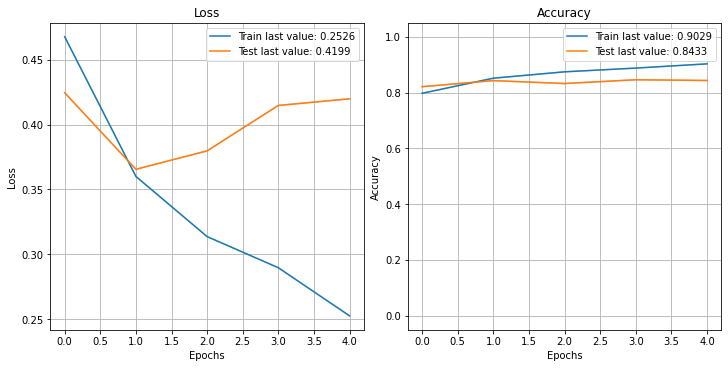

In [19]:
plot_history(history)

# Save model 

In [20]:
with open('models/model.{}.pickle'.format(datetime.now().strftime('%Y_%m_%d__%H_%M')), 'wb') as wf:
    pickle.dump(model, wf)

TypeError: can't pickle weakref objects

# Prediction
copy the cell below any time you want to use your model on some data X. Also grab the relevant functions from above...

In [ ]:
with open('models/model.2021_04_16__12_34.pickle','r') as rf:
    trained_model = pickle.load(rf)
with open('models/tokenizer.pickle','r') as rf:
    trained_tokenizer = pickle.load(rf)

In [ ]:
def predict(trained_model, trained_tokenizer, txt):
    clean_input = preprocess([txt], trained_tokenizer)
    return trained_model.predict(clean_input)

In [ ]:
predict(trained_model, trained_tokenizer, "test text just to make sure it works.")